# Time Series Forecasting with Python 7-Day Mini-Course
Ref: https://machinelearningmastery.com/time-series-forecasting-python-mini-course/

Using the ml env.

Later addition:
    Found this incredibly helpful resource on medium:
    https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [131]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-total-female-births.csv"
data = pd.read_csv(url, header=0, index_col=0)
data.head()

,Births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


Note that the date is the index in the above dataset. This is common for time series data.

In [132]:
data.describe(include='all')

,Births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


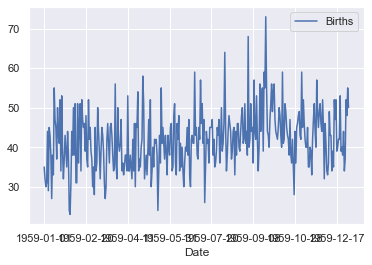

In [133]:
data.plot()
plt.show()

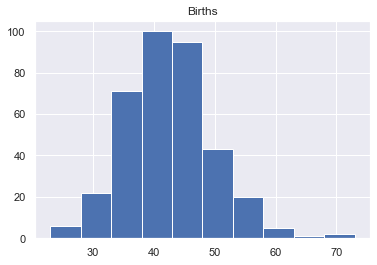

In [134]:
data.hist()
plt.show()

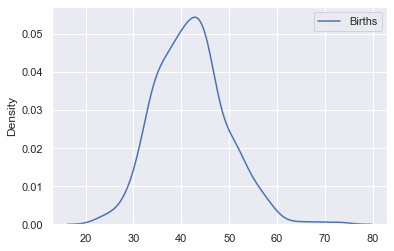

In [135]:
# Density plot (KDE = kernel density estimate)
sns.kdeplot(data=data)
plt.show()

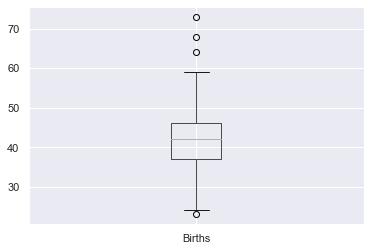

In [136]:
data.boxplot()
plt.show()

### Persistence Forecast Model
The simplest forecast you can make is the current observation ($t$) to predict the observation at the next time step ($t+1$).

This is called the **naive forecast** or the persistence forecast and may be the best possible model on some time series forecast problems (how vague is that??).

In [137]:
import sklearn.metrics as metrics
import numpy as np

In [138]:
# Rolling window / sliding window
rolling_data = data.copy()
# rolling_data["Past"] = rolling_data.loc[:, "Births"].rolling(window=2).sum()
rolling_data.loc[:, "Past"] = rolling_data.loc[:, "Births"].shift()
rolling_data

,Births,Past
Date,,
1959-01-01,35,NaN
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
...,...,...
1959-12-27,37,34.0
1959-12-28,52,37.0
1959-12-29,48,52.0


In [139]:
# Something I'll add from the medium article I found
# One thing I'm not sure of is whether the difference adds leakage....
# Edit: doesn't add leakage since it's the difference of yesterday's values
# rolling_data.loc[:, "Past_Diff"] = rolling_data.loc[:, "Past"].diff()
rolling_data

,Births,Past
Date,,
1959-01-01,35,NaN
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
...,...,...
1959-12-27,37,34.0
1959-12-28,52,37.0
1959-12-29,48,52.0


In [140]:
# Drops the rows with NaN's
rolling_data = rolling_data.dropna()
rolling_data

,Births,Past
Date,,
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0
1959-01-06,29,44.0
...,...,...
1959-12-27,37,34.0
1959-12-28,52,37.0
1959-12-29,48,52.0


In [141]:
def regression_results(y_true, y_pred):
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mean_squared_error = metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    print("Explained Variance: ", round(explained_variance, 4))
    print("Mean Squared Log Error: ", round(mean_squared_log_error, 4))
    print("R2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mean_squared_error, 4))
    print("RMSE: ", round(np.sqrt(mean_squared_error), 4))

## Training and test sets
I'll include this from the medium article since I find the methodology interesting, and it makes sense looking at it.

In [142]:
X_train = rolling_data[:"1959-10"].drop(["Births"], axis=1)
y_train = rolling_data.loc[:"1959-10", "Births"]

X_test = rolling_data["1959-10":].drop(["Births"], axis=1)
y_test = rolling_data.loc["1959-10":, "Births"]

# Making sure dates don't intersect & that indexing was done correctly
print(y_test.shape, X_test.shape)

(92,) (92, 1)


In [143]:
def model_persistence(x):
    """Naive/persistence model"""
    return x

In [144]:
pred = []
for x in X_test.values:
    yhat = model_persistence(x)
    pred.append(yhat)
test_score = np.sqrt(metrics.mean_squared_error(y_test, pred))
print(f"Test RMSE: {test_score:.3f}")

Test RMSE: 7.633


So our baseline MSE is $7.633$.

In [145]:
from statsmodels.tsa.ar_model import AutoReg

## AutoReg

In [146]:
train = pd.concat([y_train, X_train], axis=1).loc[:, "Past"]
model = AutoReg(train, lags=2)
model_fit = model.fit()

C:\Users\gamet\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [147]:
test = pd.concat([y_test, X_test], axis=1).loc[:, "Births"]
coef = model_fit.params
history = train[len(train)-2:]
history = [history[i] for i in range(len(history))]
pred = []
for i in range(len(test)):
    length = len(history)
    lag = [history[j] for j in range(length-2, length)]
    yhat = coef[0]
    for k in range(2):
        yhat += coef[k+1] * lag[2-k-1]
    obs = test[i]
    pred.append(yhat)
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(metrics.mean_squared_error(test, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 6.390


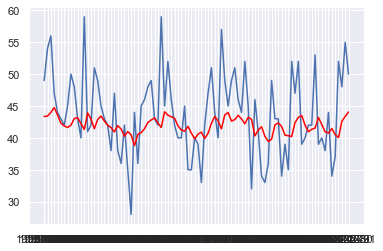

In [148]:
plt.plot(test)
plt.plot(pred, color='red')
plt.show()

In [149]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

## ARIMA

In [150]:
result = adfuller(train.values)
print(f"ADF Stat: {result[0]}")
print(f"p-value: {result[1]}")
print(f"Critical Values: ")
for key, value, in result[4].items():
    print(f"{key}: {value}")

ADF Stat: -3.3258210893177256
p-value: 0.013762992888953362
Critical Values: 
1%: -3.455365238788105
5%: -2.8725510317187024
10%: -2.5726375763314966


Since the p-value is less than 0.05 & the ADF stat is less than/super close to the critical values suggest that the time series is stationary. Since the time series data is stationary, we'll set the $d$ parameter to 0.

In [151]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    
    lags = range(2, max_lag)

    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]

    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

Hurst exponent shows the trend of the data.

$H>0.5$ means it's trending

$H=0.5$ shows random walk/Brownian motion

$H<0.5$ means it's mean-reverting (stationary)

20 lags is what's used in Matplotlib's implementation.

In [154]:
hurst_exp = get_hurst_exponent(rolling_data.loc[:,"Births"].values)
print(f"Hurst exponent with 20 lags: {hurst_exp:.3f}")

Hurst exponent with 20 lags: 0.022


Supporting evidence that our data is stationary!

In [153]:
# better way of writing the code, as opposed to above in AutoReg
history = train.values
predictions = []
for t in test.values:
    model = ARIMA(train, order=(3,0,3))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history = np.append(history, t) # have to use np because it's an ndarray
    # print('predicted=%f, expected=%f' % (yhat, t))
rmse = np.sqrt(metrics.mean_squared_error(test, predictions))
print(f'Test RMSE: {rmse:.3f}')

NameError: name 'order' is not defined

In [ ]:
f = model_fit.forecast()
f
# plt.plot(test)
# plt.plot(f, color='red')
# plt.show()

1959-10-01    61.436294
Freq: D, dtype: float64